In [1]:
%config InlineBackend.figure_format='retina'

In [2]:
import json

from pyTrajectory.config import cfg

from pyTrajectory.io import load_trajectories, load_data
from pyTrajectory.xarray_wrappers import Trajectory

import pandas as pd
import numpy as np

from pyTrajectory.dataset import to_annotations, AnnotatedDyad

cfg.key_keypoints = "keypoints"
cfg.key_timestamp = "timestamps"

cfg.trajectory_keys = (
    "keypoints",
    "timestamps",
)

In [3]:
def load_calms21_dyads(calms21_json_file, categories=("attack", "investigation", "mount")):
    dyads = []
    with open(calms21_json_file) as json_file:
        json_data = json.load(json_file)
        for data in json_data.values():
            for pair in [key for key in data.keys()]:
                pair_data = data.pop(pair)
                dyads.append(
                    AnnotatedDyad(
                        Trajectory(
                            data={
                                "keypoints": np.asarray(pair_data["keypoints"])[:, 0].transpose(0, 2, 1),
                                "timestamps": np.arange(len(pair_data["keypoints"])),
                            }
                        ),
                        Trajectory(
                            data={
                                "keypoints": np.asarray(pair_data["keypoints"])[:, 1].transpose(0, 2, 1),
                                "timestamps": np.arange(len(pair_data["keypoints"])),
                            }
                        ),
                        annotations=to_annotations(
                            np.asarray(pair_data["annotations"]),
                            category_names = ["attack", "investigation", "mount", "other"],
                            drop=["other"]
                        ),
                        categories=categories,
                    )
                )
    del data
    return dyads

In [4]:
dyads_train = load_calms21_dyads("/media/paul/Data/asoid_testing/calms21_task1_train.json")

In [5]:
dyads_test = load_calms21_dyads("/media/paul/Data/asoid_testing/calms21_task1_test.json")

In [6]:
durations = np.concatenate([dyad.durations() for dyad in dyads_train])

In [7]:
import pyTrajectory.sliding_metrics as ptsm

In [8]:
import pyTrajectory.features as ptf

In [191]:
from pyTrajectory.features import DataFrameFeatureExtractor

# {
#     0: "nose",
#     1: "left ear",
#     2: "right ear",
#     3: "neck",
#     4: "left hip",
#     5: "right hip",
#     6: "tail base",
# }

feature_config = {
    "individual": [
        # step 5
        ("speed", {"step": 5, "keypoints": (0, 3, 6)}),
        ("projected_velocity", {"step": 5, "keypoints_1": (0, 1, 2, 3, 4, 5, 6), "keypoint_pairs_2": ((6, 3), ), "discard": "-rej"}),
        ("projected_velocity", {"step": 5, "keypoints_1": (0, 1, 2, 3, 4, 5, 6), "keypoint_pairs_2": ((6, 3), ), "as_absolute": True, "discard": "-proj"}),
        ("orientation_change", {"step": 5, "keypoint_pairs": ((3, 0), (6, 3)), "as_absolute": True}),
        # step 30
        ("speed", {"step": 30, "keypoints": (0, 3, 6)}),
        ("projected_velocity", {"step": 30, "keypoints_1": (0, 1, 2, 3, 4, 5, 6), "keypoint_pairs_2": ((6, 3), ), "discard": "-rej"}),
        ("projected_velocity", {"step": 30, "keypoints_1": (0, 1, 2, 3, 4, 5, 6), "keypoint_pairs_2": ((6, 3), ), "as_absolute": True, "discard": "-proj"}),
        ("orientation_change", {"step": 30, "keypoint_pairs": ((3, 0), (6, 3)), "as_absolute": True}),
        # step 15
        ("speed", {"step": 15, "keypoints": (0, 3, 6)}),
        ("projected_velocity", {"step": 15, "keypoints_1": (0, 1, 2, 3, 4, 5, 6), "keypoint_pairs_2": ((6, 3), ), "discard": "-rej"}),
        ("projected_velocity", {"step": 15, "keypoints_1": (0, 1, 2, 3, 4, 5, 6), "keypoint_pairs_2": ((6, 3), ), "as_absolute": True, "discard": "-proj"}),
        # # ("projected_velocity", {"step": 15, "keypoints_1": (3, ), "keypoint_pairs_2": ((6, 3), ), "as_sign_change_latency": True, "discard": "-proj"}),
        ("orientation_change", {"step": 15, "keypoint_pairs": ((3, 0), (3, 1), (3, 2), (6, 3), (6, 4), (6, 5)), "as_absolute": True}),
        # # ("orientation_change", {"step": 15, "keypoint_pairs": ((3, 0), (6, 3)), "as_sign_change_latency": True}),
        (
            "posture_angles",
            {
                "keypoint_pairs_1": ((6, 3), (3, 0), (3, 0), (6, 3), (6, 3)),
                "keypoint_pairs_2": ((3, 0), (3, 1), (3, 2), (6, 4), (6, 5)),
                "element_wise": True
            }
        ),
    ],
    "dyadic": [
        ("target_velocity", {"step": 5, "keypoints_1": (0, 3), "keypoint_pairs_2": ((0, 0), (0, 3), (0, 6), (3, 0), (3, 3), (3, 6)), "discard": "-rej"}),
        ("target_velocity", {"step": 30, "keypoints_1": (0, 3), "keypoint_pairs_2": ((0, 0), (0, 3), (0, 6), (3, 0), (3, 3), (3, 6)), "discard": "-rej"}),
        ("target_velocity", {"step": 15, "keypoints_1": (0, 3), "keypoint_pairs_2": ((0, 0), (0, 3), (0, 6), (3, 0), (3, 3), (3, 6)), "discard": "-rej"}),
        ("target_velocity", {"step": 5, "keypoints_1": (0, 3), "keypoint_pairs_2": ((0, 0), (0, 3), (0, 6), (3, 0), (3, 3), (3, 6)), "as_absolute": True, "discard": "-proj"}),
        ("target_velocity", {"step": 30, "keypoints_1": (0, 3), "keypoint_pairs_2": ((0, 0), (0, 3), (0, 6), (3, 0), (3, 3), (3, 6)), "as_absolute": True, "discard": "-proj"}),
        ("target_velocity", {"step": 15, "keypoints_1": (0, 3), "keypoint_pairs_2": ((0, 0), (0, 3), (0, 6), (3, 0), (3, 3), (3, 6)), "as_absolute": True, "discard": "-proj"}),
        ("keypoint_distances", {"keypoints_1": (0, 1, 2, 3, 4, 5, 6), "keypoints_2": (0, 1, 2, 3, 4, 5, 6)}),
        ("target_angles", {"keypoint_pairs_1": ((3, 0), (6, 3)), "keypoints_2": (0, 1, 2, 3, 4, 5, 6), "as_absolute": True}),
        ("posture_alignment", {"keypoint_pairs_1": ((3, 0), (6, 3)), "keypoint_pairs_2": ((3, 0), (6, 3))}),
        ("target_angles", {"keypoint_pairs_1": ((3, 0), (6, 3)), "keypoints_2": (0, 3, 6), "as_sign_change_latency": True}),
    ]
    
}

extractor = DataFrameFeatureExtractor().load(feature_config)

In [10]:
# from sklearn.preprocessing import KBinsDiscretizer

# from sklearn.compose import ColumnTransformer
# from sklearn.preprocessing import MinMaxScaler, PowerTransformer, QuantileTransformer, FunctionTransformer
# from sklearn.decomposition import PCA, IncrementalPCA

# from sklearn.cluster import KMeans


# def get_column_transformer(columns):
#     alternative_transformer = Pipeline(
#         [
#             ("k_bins", KBinsDiscretizer(n_bins=20, encode="ordinal")),  # pass random state
#             ("min_max", MinMaxScaler(clip=True)),
#         ])
#     default_transformer = QuantileTransformer(output_distribution="normal")  # pass random state
#     return ColumnTransformer(
#         [
#             ("quantile_transformer", default_transformer, [column for column in columns if "scl" not in column]),
#             ("k_bins_discretizer", alternative_transformer, [column for column in columns if "scl" in column])
#         ],
#         n_jobs=-1,
#     )

In [11]:
aggregator = ptsm.SlidingWindowAggregator(
    [
        ptsm.metrics.mean,
        ptsm.metrics.median,
        ptsm.metrics.min,
        ptsm.metrics.max,
        ptsm.metrics.q10,
        ptsm.metrics.q90,
        # ptsm.as_window_delta(ptsm.metrics.mean),
        # ptsm.as_window_delta(ptsm.metrics.median),
        # ptsm.as_window_delta(ptsm.metrics.min),
        # ptsm.as_window_delta(ptsm.metrics.max),
        # ptsm.as_window_delta(ptsm.metrics.q10),
        # ptsm.as_window_delta(ptsm.metrics.q90),
    ],
    *ptsm.get_window_slices(1, durations=durations, time_scale_quantiles=[0.1, 0.5]),
)

# scaler = get_column_transformer(aggregator.get_feature_names_out(extractor.feature_names))

Time scales adjusted to match num_windows_per_scale: [10, 38] -> [9, 37].


In [192]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer

In [193]:
from tqdm.auto import tqdm

In [194]:
for dyad in dyads_train:
    dyad.X = None
    dyad.y = None
    dyad.X_subsampled = None
    dyad.y_subsampled = None

for dyad in dyads_test:
    dyad.X = None
    dyad.y = None
    dyad.X_subsampled = None
    dyad.y_subsampled = None

In [195]:
import warnings


feature_extraction_pipeline = Pipeline([("imputer", KNNImputer())])  # , ("aggregator", aggregator)
feature_extraction_pipeline.set_output(transform="pandas")

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", message="^.*Bins whose width are too small.*$", append=True)
    warnings.filterwarnings("ignore", message="^.*n_quantiles is set to n_samples.*$", append=True)

    datasets_train = [
        dyad.sample(
            extractor,
            pipeline=feature_extraction_pipeline,
        ).dataset
        for dyad in tqdm(dyads_train)
        if len(dyad.trajectory) > 60
    ]
    datasets_test = [
        dyad.sample(
            extractor,
            pipeline=feature_extraction_pipeline,
        ).dataset
        for dyad in tqdm(dyads_test)
        if len(dyad.trajectory) > 60
    ]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

In [196]:
try:
    del X_train
    del y_train
    
    del X_test
    del y_test
except NameError:
    pass

In [197]:
X_train = pd.concat([dataset[0] for dataset in datasets_train])
y_train = np.concatenate([dataset[1] for dataset in datasets_train])

X_test = pd.concat([dataset[0] for dataset in datasets_test])
y_test = np.concatenate([dataset[1] for dataset in datasets_test])

del datasets_train
del datasets_test

In [200]:
X_train.shape

(507738, 211)

In [201]:
from sklearn.model_selection import train_test_split, GroupShuffleSplit

In [202]:
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [22]:
# groups = np.concatenate([np.repeat(idx, len(dataset[0])) for idx, dataset in enumerate(datasets_train)])

In [ ]:
# asoid = AsoidRandomForestClassifier(
#     n_estimators=200,
#     class_weight="balanced_subsample",
#     n_jobs=-1,
# ).fit(X_train,
#       encoder.transform(y_train.reshape(-1, 1)),
#       groups=groups,
#       num_iterations=10)

In [23]:
# rfc = RandomForestClassifier(
#     n_estimators=200,
#     class_weight="balanced_subsample",
#     n_jobs=-1
# ).fit(X_train, encoder.transform(y_train.reshape(-1, 1)))

In [24]:
from xgboost import XGBClassifier

In [25]:
from sklearn.utils.class_weight import compute_sample_weight

In [ ]:
# column_transformer = get_column_transformer(X_train.columns)
# pca = IncrementalPCA(n_components=200, whiten=True)
# classifier = RandomForestClassifier(n_estimators=200, class_weight="balanced_subsample", n_jobs=-1, verbose=True)

# pipeline = Pipeline(
#     [
#         # ("transformer", column_transformer),
#         # ("pca", pca),
#         ("classifier", classifier),
#     ],
#     verbose=True,
# )
# pipeline.set_output(transform="pandas")

In [203]:
encoder = OneHotEncoder(sparse_output=False).fit(y_train.reshape(-1, 1))

In [204]:
from sklearn.ensemble import RandomForestClassifier

In [205]:
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, category_labels):
    cm = confusion_matrix(y_true, y_pred)
    cm_prob = (cm.T / cm.sum(axis=1)).T
    
    fig = plt.figure(figsize=(3, 3), dpi=100)
    axes = fig.subplots(1, 2, width_ratios=[20, 1])
    mappable = axes[0].matshow(cm_prob, vmin=0, vmax=1)
    grid = np.indices(cm_prob.shape)
    for row_idx, col_idx in zip(grid[0].ravel(), grid[1].ravel()):
        axes[0].text(
            col_idx,
            row_idx,
            f"{cm_prob[row_idx, col_idx]:.2f}\n({cm[row_idx, col_idx]})",
            ha="center",
            va="center",
            c="k" if cm_prob[row_idx, col_idx] > 0.5 else "w",
            fontsize=8,
        )
    
    plt.colorbar(mappable, cax=axes[1])
    
    axes[0].set_yticks(range(len(category_labels)))
    axes[0].set_yticklabels(category_labels, rotation=90, va="center")
    axes[0].set_ylabel("Annotated")
    
    axes[0].set_xticks(range(len(category_labels)))
    axes[0].set_xticklabels(category_labels)
    axes[0].set_xlabel("Predicted")
    
    axes[0].xaxis.set_ticks_position("bottom")
    axes[1].yaxis.set_ticks_position("right")
    
    bbox = axes[0].get_position()
    bbox_cbar = axes[1].get_position()
    bbox_cbar.intervaly = bbox.intervaly
    axes[1].set_position(bbox_cbar)
    plt.show()

In [206]:
rfc = RandomForestClassifier(
    n_estimators=200,
    class_weight="balanced_subsample",
    n_jobs=-1,
).fit(
    X_train,
    encoder.transform(y_train.reshape(-1, 1)),
)

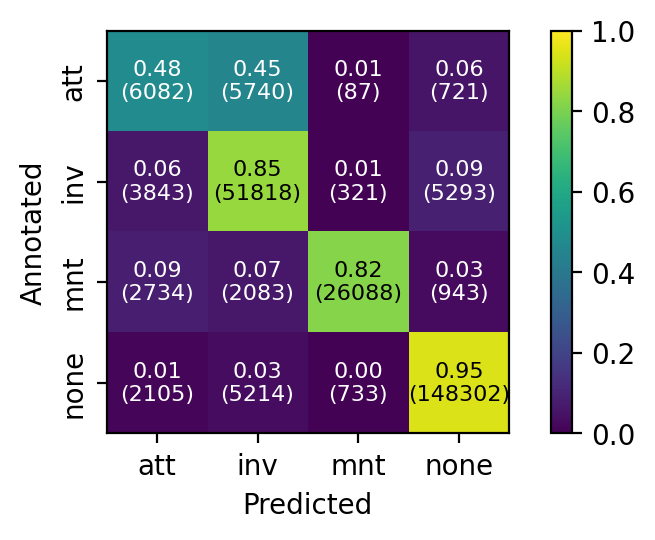

In [207]:
y_pred = rfc.predict(X_test)
y_pred_categorical = np.argmax(y_pred, axis=1)
y_test_categorical = np.argmax(encoder.transform(y_test.reshape(-1, 1)), axis=1)

plot_confusion_matrix(y_test_categorical, y_pred_categorical, ["att", "inv", "mnt", "none"])

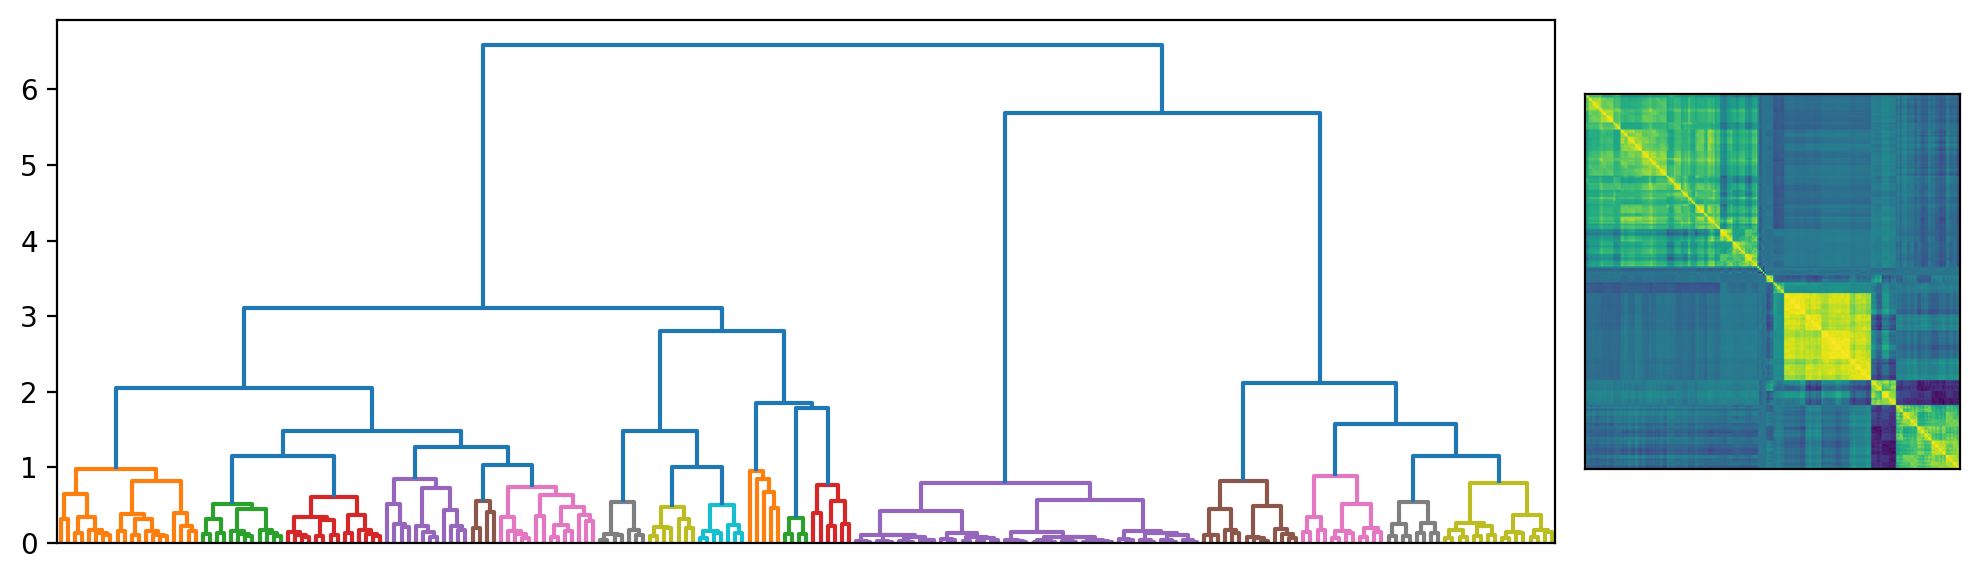

In [211]:
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from scipy.stats import spearmanr

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3), dpi=100, width_ratios=[4, 1])
corr = spearmanr(X_train).correlation

# Ensure the correlation matrix is symmetric
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

# We convert the correlation matrix to a distance matrix before performing
# hierarchical clustering using Ward's linkage.
distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))
dendro = hierarchy.dendrogram(
    dist_linkage, labels=X_train.columns.to_list(), ax=ax1, leaf_rotation=90, color_threshold=1.0,
)
ax1.set_xticks([])

dendro_idx = np.arange(0, len(dendro["ivl"]))

ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]])
ax2.set_xticks([])  # 
ax2.set_yticks([])  # 
# ax2.set_xticklabels(dendro["ivl"], rotation="vertical")
# ax2.set_yticklabels(dendro["ivl"])
fig.tight_layout()
plt.show()

In [213]:
cluster_ids = hierarchy.fcluster(dist_linkage, 1.0, criterion="distance")
np.unique(cluster_ids, return_counts=True)[1]

array([20, 12, 14, 12,  4, 14,  7,  7,  7,  5,  4,  6, 49, 14, 12,  8, 16])

In [215]:
from collections import defaultdict

cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)

results = []
for idx in tqdm(range(max([len(v) for v in cluster_id_to_feature_ids.values()]))):

    selected_features = [(v[idx] if idx < len(v) else np.random.choice(v)) for v in cluster_id_to_feature_ids.values()]
    selected_features_names = X_train.columns[selected_features]
    
    X_train_sel = X_train[selected_features_names]
    X_test_sel = X_test[selected_features_names]
    
    clf_sel = RandomForestClassifier(n_estimators=200, n_jobs=-1, class_weight="balanced_subsample")
    clf_sel.fit(X_train_sel, encoder.transform(y_train.reshape(-1, 1)))

    # y_pred = clf_sel.predict(X_test_sel)
    # y_pred_categorical = np.argmax(y_pred, axis=1)
    # y_test_categorical = np.argmax(encoder.transform(y_test.reshape(-1, 1)), axis=1)
    
    # plot_confusion_matrix(y_test_categorical, y_pred_categorical, ["att", "inv", "mnt", "none"])

    result = permutation_importance(
        clf_sel,
        X_test_sel,
        encoder.transform(y_test.reshape(-1, 1)),
        sample_weight=compute_sample_weight("balanced", encoder.transform(y_test.reshape(-1, 1))),
        n_repeats=10,
        n_jobs=1,
    )
    result["selection"] = np.asarray(X_train_sel.columns)
    results.append(result)

  0%|          | 0/49 [00:00<?, ?it/s]

In [218]:
import _pickle

with open("feature_importances.pkl", "wb") as fid:
    _pickle.dump(results, fid)

In [219]:
feature_importance = pd.concat([pd.DataFrame(result["importances"].T, columns=result["selection"]) for result in results], axis=0).aggregate(np.nanmean, axis=0)

/tmp/ipykernel_1735643/2895955768.py:1: FutureWarning: The provided callable <function nanmean at 0x7f0cc4d819e0> is currently using DataFrame.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  feature_importance = pd.concat([pd.DataFrame(result["importances"].T, columns=result["selection"]) for result in results], axis=0).aggregate(np.nanmean, axis=0)


In [220]:
features_sort_idx = np.asarray([np.argmax(rfc.feature_names_in_ == name) for name in feature_importance.index])

In [250]:
from matplotlib.colors import to_rgba_array

In [255]:
feature_importance.index

Index(['speed_t[5]-0', 'speed_t[5]-6', 'projected_velocity_t[5]-0-6_3-proj',
       'speed_t[30]-0', 'projected_velocity_t[30]-0-6_3-proj',
       'abs_orientation_change_t[30]-3_0', 'speed_t[15]-0',
       'projected_velocity_t[15]-0-6_3-proj', 'posture_angles-6_3-3_0',
       'target_velocity_t[5]-0-0_0-proj',
       ...
       'keypoint_distances-5-4', 'keypoint_distances-5-5',
       'keypoint_distances-5-6', 'keypoint_distances-6-0',
       'keypoint_distances-6-1', 'keypoint_distances-6-2',
       'keypoint_distances-6-3', 'keypoint_distances-6-4',
       'keypoint_distances-6-5', 'keypoint_distances-6-6'],
      dtype='object', length=211)

In [276]:
is_distance = np.asarray([("keypoint_distances" in name) for name in feature_importance.index[np.argsort(feature_importance)]])
is_speed_5 = np.asarray([("speed_t[5]" in name) for name in feature_importance.index[np.argsort(feature_importance)]])
is_speed_15 = np.asarray([("speed_t[15]" in name) for name in feature_importance.index[np.argsort(feature_importance)]])
is_speed_30 = np.asarray([("speed_t[30]" in name) for name in feature_importance.index[np.argsort(feature_importance)]])
is_target_velocity_5_proj = np.asarray([("target_velocity_t[5]" in name and "-proj" in name) for name in feature_importance.index[np.argsort(feature_importance)]])
is_target_velocity_5_rej = np.asarray([("target_velocity_t[5]" in name and "-rej" in name) for name in feature_importance.index[np.argsort(feature_importance)]])
is_target_velocity_15_proj = np.asarray([("target_velocity_t[15]" in name and "-proj" in name) for name in feature_importance.index[np.argsort(feature_importance)]])
is_target_velocity_15_rej = np.asarray([("target_velocity_t[15]" in name and "-rej" in name) for name in feature_importance.index[np.argsort(feature_importance)]])
is_target_velocity_30_proj = np.asarray([("target_velocity_t[30]" in name and "-proj" in name) for name in feature_importance.index[np.argsort(feature_importance)]])
is_target_velocity_30_rej = np.asarray([("target_velocity_t[30]" in name and "-rej" in name) for name in feature_importance.index[np.argsort(feature_importance)]])
is_projected_velocity_5_proj = np.asarray([("projected_velocity_t[5]" in name and "-proj" in name) for name in feature_importance.index[np.argsort(feature_importance)]])
is_projected_velocity_5_rej = np.asarray([("projected_velocity_t[5]" in name and "-rej" in name) for name in feature_importance.index[np.argsort(feature_importance)]])
is_projected_velocity_15_proj = np.asarray([("projected_velocity_t[15]" in name and "-proj" in name) for name in feature_importance.index[np.argsort(feature_importance)]])
is_projected_velocity_15_rej = np.asarray([("projected_velocity_t[15]" in name and "-rej" in name) for name in feature_importance.index[np.argsort(feature_importance)]])
is_projected_velocity_30_proj = np.asarray([("projected_velocity_t[30]" in name and "-proj" in name) for name in feature_importance.index[np.argsort(feature_importance)]])
is_projected_velocity_30_rej = np.asarray([("projected_velocity_t[30]" in name and "-rej" in name) for name in feature_importance.index[np.argsort(feature_importance)]])
is_orientation_change_5 = np.asarray([("orientation_change_t[5]" in name) for name in feature_importance.index[np.argsort(feature_importance)]])
is_orientation_change_15 = np.asarray([("orientation_change_t[15]" in name) for name in feature_importance.index[np.argsort(feature_importance)]])
is_orientation_change_30 = np.asarray([("orientation_change_t[30]" in name) for name in feature_importance.index[np.argsort(feature_importance)]])
is_posture_angles = np.asarray([("posture_angles" in name) for name in feature_importance.index[np.argsort(feature_importance)]])
is_target_angles = np.asarray([("target_angles" in name) for name in feature_importance.index[np.argsort(feature_importance)]])
is_posture_alignment = np.asarray([("posture_alignment" in name) for name in feature_importance.index[np.argsort(feature_importance)]])

In [281]:
feature_type = np.transpose(
    [
        is_distance,
        is_speed_5,
        is_speed_15,
        is_speed_30,
        is_target_velocity_5_proj,
        is_target_velocity_5_rej,
        is_target_velocity_15_proj,
        is_target_velocity_15_rej,
        is_target_velocity_30_proj,
        is_target_velocity_30_rej,
        is_projected_velocity_5_proj,
        is_projected_velocity_5_rej,
        is_projected_velocity_15_proj,
        is_projected_velocity_15_rej,
        is_projected_velocity_30_proj,
        is_projected_velocity_30_rej,
        is_orientation_change_5,
        is_orientation_change_15,
        is_orientation_change_30,
        is_posture_angles,
        is_target_angles,
        is_posture_alignment,
    ]
).argmax(axis=1)

In [282]:
colors = to_rgba_array(["red", "black"])

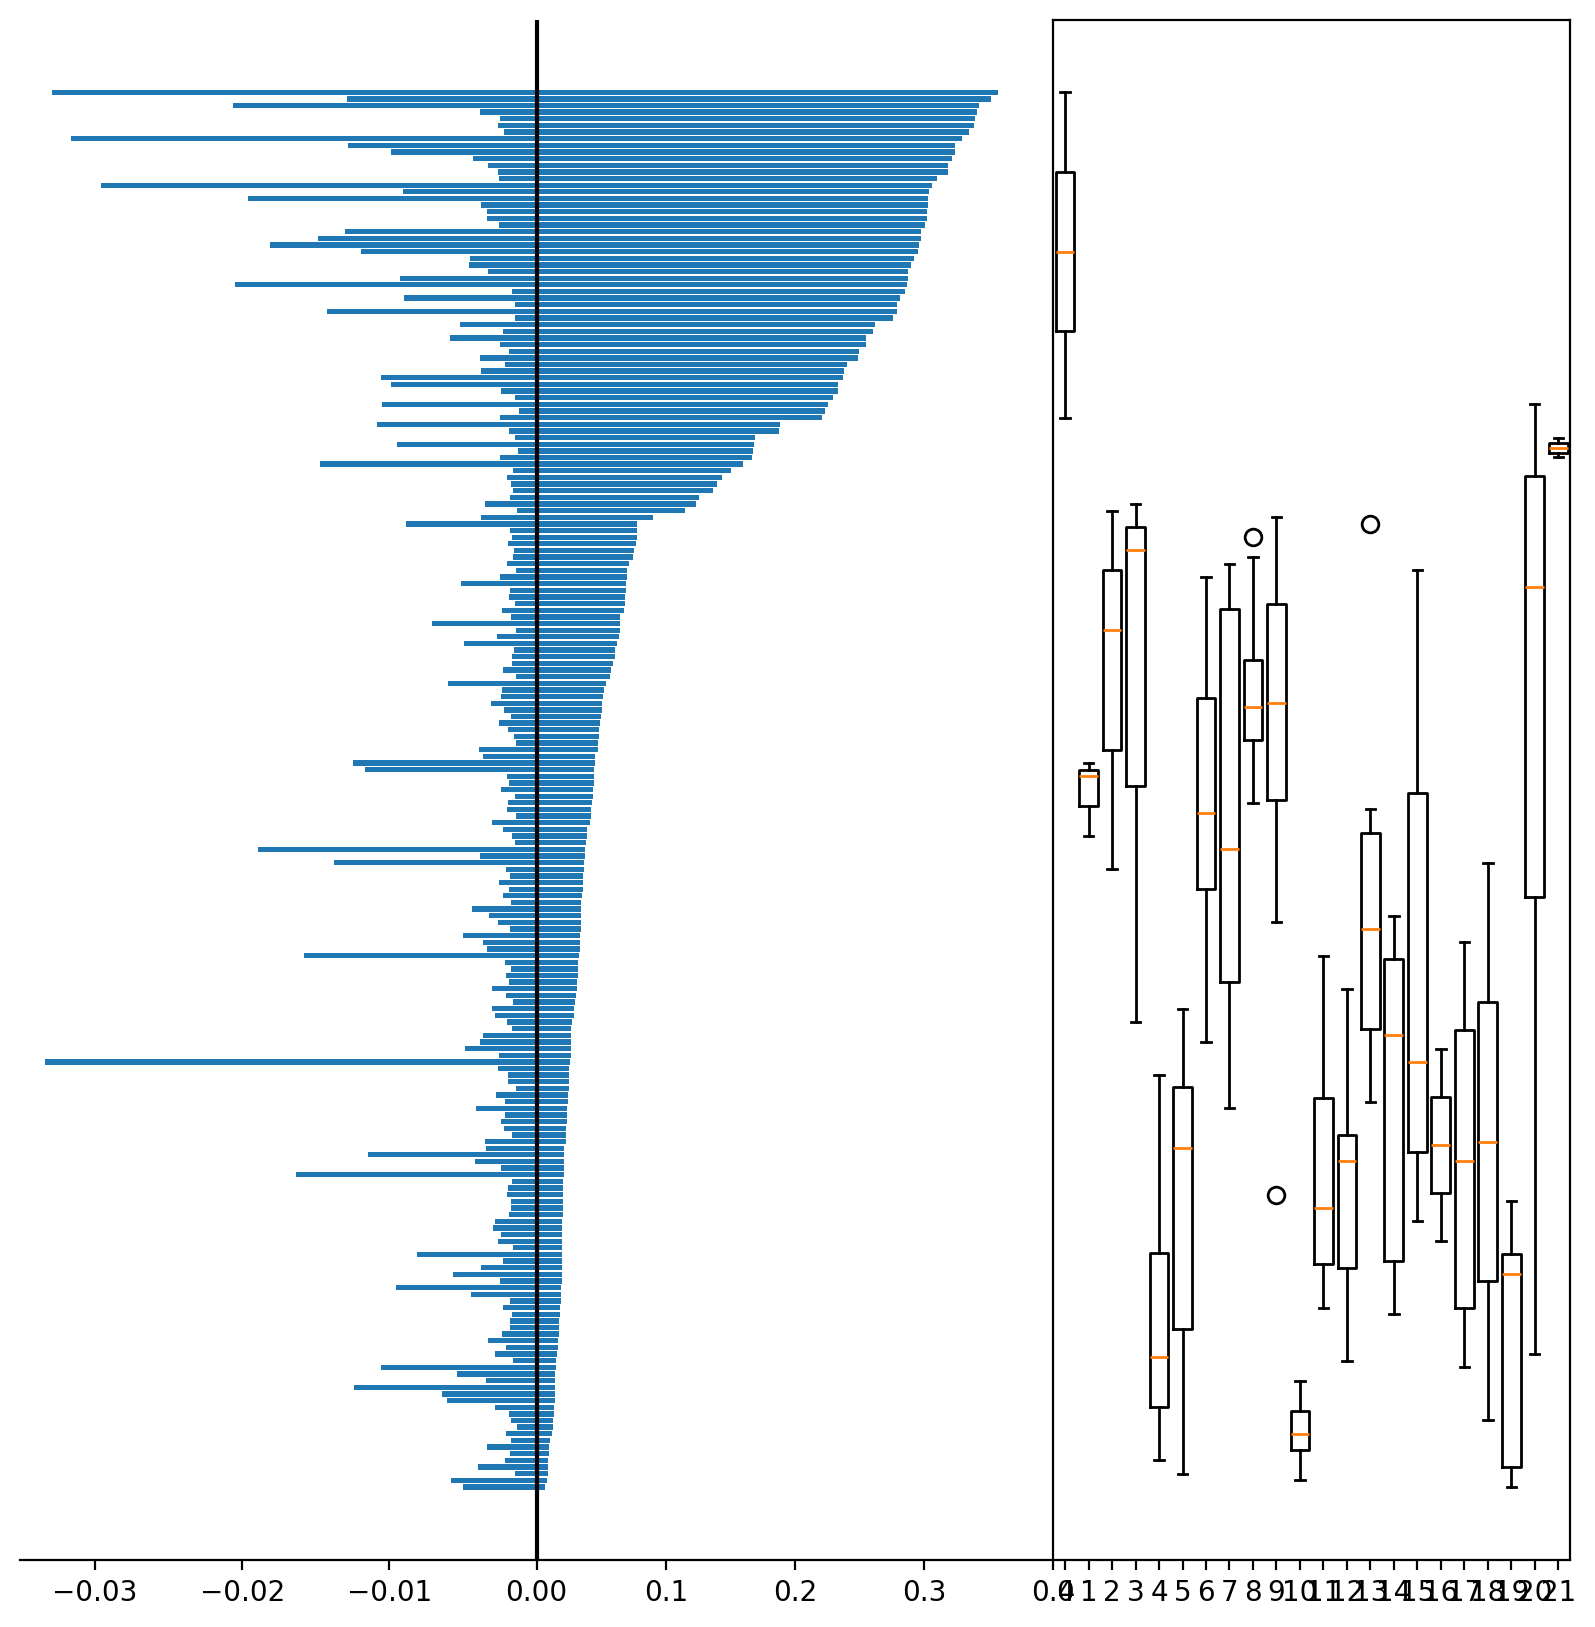

In [333]:
fig, axes = plt.subplots(1, 3, figsize=(10, 10), dpi=100, sharey=True, gridspec_kw=dict(wspace=0))

ticks = np.arange(feature_importance.shape[0])
axes[1].barh(
    y=ticks,
    width=np.asarray(feature_importance)[np.argsort(feature_importance)],
)

axes[0].barh(
    y=ticks,
    width=-rfc.feature_importances_[features_sort_idx],
)

for _feature_type in np.unique(feature_type):
    _y = np.argwhere(feature_type == _feature_type).ravel()
    axes[2].boxplot([_y], positions=[_feature_type], widths=0.8)

# plt.gca().set_yticks(ticks * 2)
# plt.gca().set_yticklabels(feature_importance.index[np.argsort(feature_importance)], fontsize=8)

axes[0].set_yticks([])
axes[1].set_xticks(axes[1].get_xticks()[1:])
axes[0].axvline(0, c="k")
axes[1].axvline(0, c="k")
axes[0].spines[["left", "right", "top"]].set_visible(False)
axes[1].spines[["left", "right", "top"]].set_visible(False)

plt.show()

In [139]:
# prop_cycle = plt.rcParams['axes.prop_cycle']
# colors = prop_cycle.by_key()['color']

In [140]:
# ticks = np.arange(rfc.feature_importances_.shape[0])
# plt.barh(
#     y=ticks,
#     width=rfc.feature_importances_[np.argsort(rfc.feature_importances_)],
#     color=np.asarray(colors)[cluster_ids[np.argsort(rfc.feature_importances_)].astype(int)]
# )
# # plt.gca().set_yticks(ticks)
# # plt.gca().set_yticklabels(rfc.feature_names_in_[np.argsort(rfc.feature_importances_)], fontsize=8)
# plt.show()

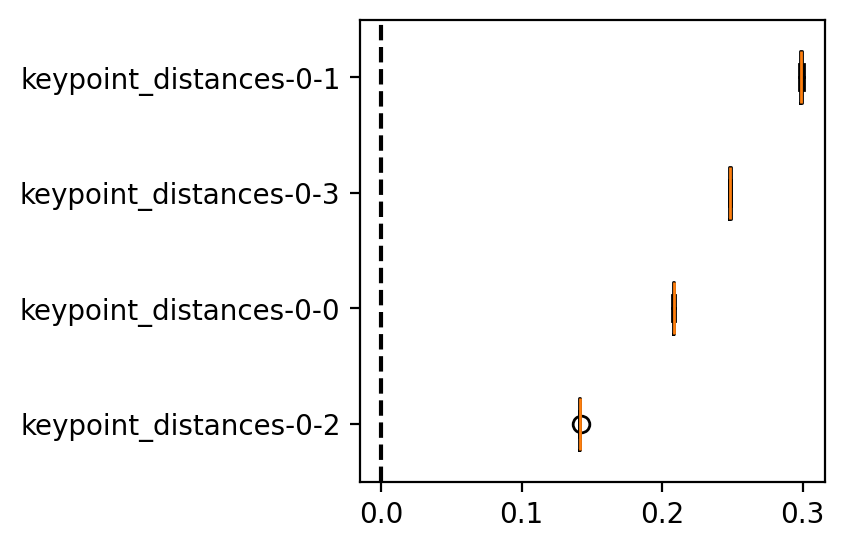

In [146]:
fig, ax = plt.subplots(figsize=(3, 3), dpi=100)

# result = permutation_importance(
#     clf_sel,
#     X_test_sel,
#     encoder.transform(y_test.reshape(-1, 1)),
#     sample_weight=compute_sample_weight("balanced", encoder.transform(y_test.reshape(-1, 1))),
#     n_repeats=10,
#     random_state=42,
#     n_jobs=2,
# )
# perm_sorted_idx = result.importances_mean.argsort()

ax.boxplot(
    result.importances[perm_sorted_idx].T,
    vert=False,
    tick_labels=X_train.columns[perm_sorted_idx],
)
ax.axvline(x=0, color="k", linestyle="--")

# ax.set_title("Permutation Importances on selected subset of features\n(test set)")
# ax.set_xlabel("Decrease in accuracy score")
# ax.figure.tight_layout()
plt.show()

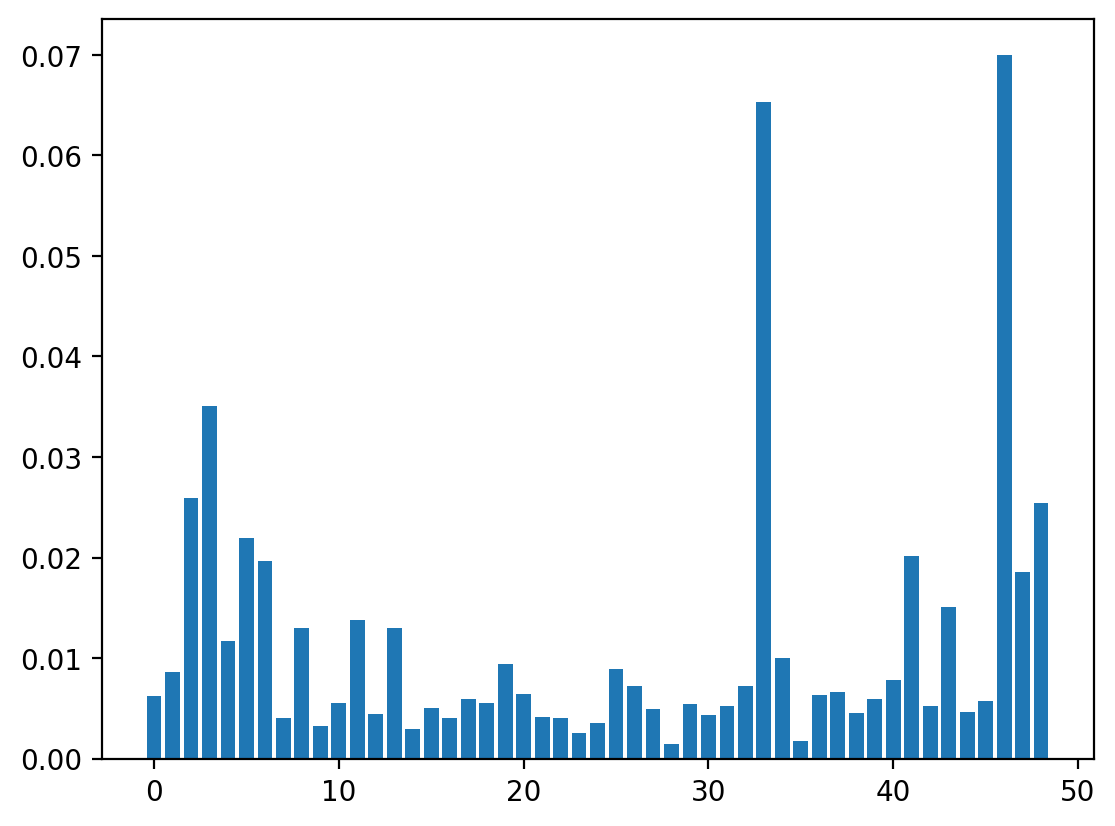

In [66]:
plt.bar(np.arange(forest_importances.shape[0]), forest_importances)
plt.show()

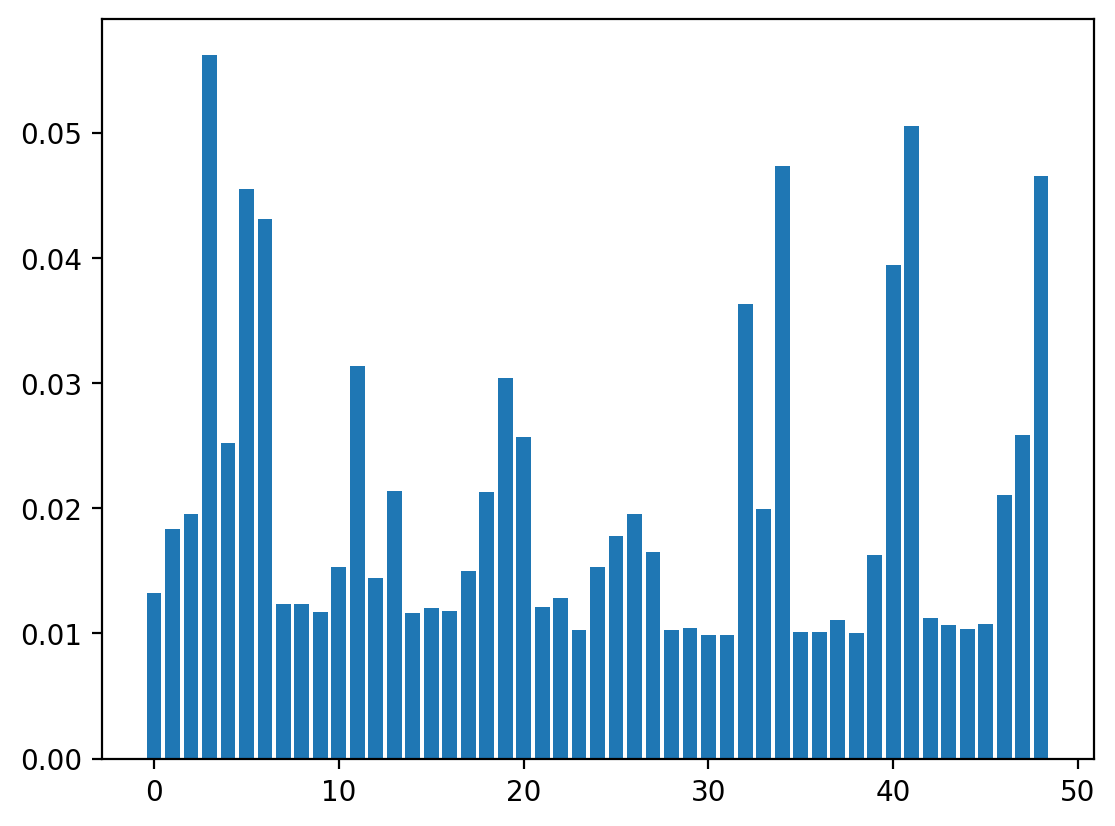

In [64]:
plt.bar(np.arange(rfc.feature_importances_.shape[0]), rfc.feature_importances_)
plt.show()

In [63]:
X_train.columns[np.argsort(rfc.feature_importances_)[::-1]]

Index(['keypoint_distances-0-3', 'keypoint_distances-5-6',
       'keypoint_distances-4-6', 'keypoint_distances-6-6',
       'keypoint_distances-0-5', 'keypoint_distances-0-6',
       'keypoint_distances-5-5', 'keypoint_distances-4-4',
       'keypoint_distances-1-4', 'keypoint_distances-2-5',
       'keypoint_distances-6-5', 'keypoint_distances-2-6',
       'keypoint_distances-0-4', 'keypoint_distances-1-6',
       'keypoint_distances-2-4', 'keypoint_distances-6-4',
       'keypoint_distances-4-5', 'keypoint_distances-3-5',
       'keypoint_distances-0-2', 'keypoint_distances-0-1',
       'keypoint_distances-3-4', 'keypoint_distances-3-6',
       'keypoint_distances-5-4', 'keypoint_distances-3-3',
       'keypoint_distances-1-3', 'keypoint_distances-2-3',
       'keypoint_distances-1-5', 'keypoint_distances-0-0',
       'keypoint_distances-3-1', 'keypoint_distances-1-1',
       'keypoint_distances-1-0', 'keypoint_distances-3-0',
       'keypoint_distances-2-1', 'keypoint_distances-2-2

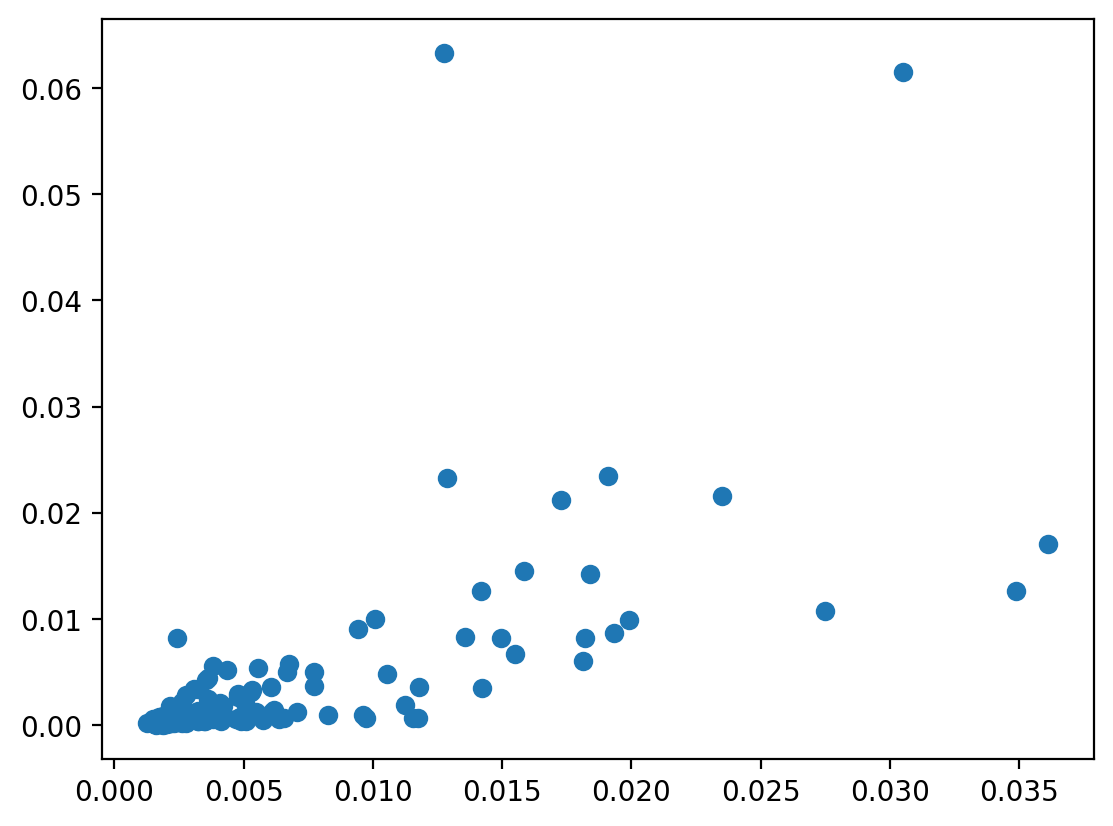

In [39]:
plt.scatter(rfc.feature_importances_, forest_importances)

In [ ]:
encoder = OneHotEncoder(sparse_output=False).fit(y_train.reshape(-1, 1))
xgbc = XGBClassifier(
    n_estimators=1000,
    device="cuda",
    tree_method="hist",
    sampling_method="gradient_based",
    subsample=0.25).fit(
        np.asarray(X_train),
        encoder.transform(y_train.reshape(-1, 1)),
        sample_weight=compute_sample_weight("balanced", encoder.transform(y_train.reshape(-1, 1))),
)

In [ ]:
y_pred = xgbc.predict(X_test)
y_pred_categorical = np.argmax(y_pred, axis=1)
y_test_categorical = np.argmax(encoder.transform(y_test.reshape(-1, 1)), axis=1)

In [ ]:
from sklearn.metrics import confusion_matrix, f1_score

f1_score(y_test_categorical, y_pred_categorical, average=None), \
f1_score(y_test_categorical, y_pred_categorical, average="weighted"), \
f1_score(y_test_categorical, y_pred_categorical, average="micro")

In [ ]:
(array([0.55795349, 0.82815033, 0.91785305, 0.94903353]),
 np.float64(0.898140213663493),
 np.float64(0.8919067403770216))

In [ ]:
pd.DataFrame(
    {
        "category": encoder.categories_[0],
        "f1_score": [
            f1_score(y_test_categorical == category, y_pred_categorical == category)
            for category in range(4)
        ],
    }
)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
labels = ["att", "inv", "mnt", "none"]

cm = confusion_matrix(y_test_categorical, y_pred_categorical)
cm_prob = (cm.T / cm.sum(axis=1)).T

fig = plt.figure(figsize=(3, 3), dpi=100)
axes = fig.subplots(1, 2, width_ratios=[20, 1])
mappable = axes[0].matshow(cm_prob, vmin=0, vmax=1)
grid = np.indices(cm_prob.shape)
for row_idx, col_idx in zip(grid[0].ravel(), grid[1].ravel()):
    axes[0].text(
        col_idx,
        row_idx,
        f"{cm_prob[row_idx, col_idx]:.2f}\n({cm[row_idx, col_idx]})",
        ha="center",
        va="center",
        c="k" if cm_prob[row_idx, col_idx] > 0.5 else "w",
        fontsize=8,
    )

plt.colorbar(mappable, cax=axes[1])

axes[0].set_yticks(range(len(labels)))
axes[0].set_yticklabels(labels, rotation=90, va="center")
axes[0].set_ylabel("True")

axes[0].set_xticks(range(len(labels)))
axes[0].set_xticklabels(labels)
axes[0].set_xlabel("Predicted")

axes[0].xaxis.set_ticks_position("bottom")
axes[1].yaxis.set_ticks_position("right")

bbox = axes[0].get_position()
bbox_cbar = axes[1].get_position()
bbox_cbar.intervaly = bbox.intervaly
axes[1].set_position(bbox_cbar)

In [ ]:
cm = confusion_matrix(y_test_categorical, y_pred_categorical)
cm_prob = (cm.T / cm.sum(axis=1)).T

fig = plt.figure(figsize=(3, 3), dpi=100)
axes = fig.subplots(1, 2, width_ratios=[20, 1])
mappable = axes[0].matshow(cm_prob, vmin=0, vmax=1)
grid = np.indices(cm_prob.shape)
for row_idx, col_idx in zip(grid[0].ravel(), grid[1].ravel()):
    axes[0].text(
        col_idx,
        row_idx,
        f"{cm_prob[row_idx, col_idx]:.2f}\n({cm[row_idx, col_idx]})",
        ha="center",
        va="center",
        c="k" if cm_prob[row_idx, col_idx] > 0.5 else "w",
        fontsize=8,
    )

plt.colorbar(mappable, cax=axes[1])

axes[0].xaxis.set_ticks_position("bottom")
axes[1].yaxis.set_ticks_position("right")

bbox = axes[0].get_position()
bbox_cbar = axes[1].get_position()
bbox_cbar.intervaly = bbox.intervaly
axes[1].set_position(bbox_cbar)

In [ ]:
def _load_sav(path, name, filename):
    """just a simplification for all those load functions"""
    with open(os.path.join(path, name, filename), 'rb') as fr:
        data = joblib.load(fr)
    return data

In [ ]:
import joblib
from pprint import pprint

In [ ]:
with open("/home/paul/Desktop/asoid_output1/Aug-21-2024/data.sav", 'rb') as fr:
    data = joblib.load(fr)
pprint(len(data))
pprint(len(data[0]))
pprint([a.shape for a in data[0]], compact=True)
pprint([a.shape for a in data[1]], compact=True)

In [ ]:
with open("/home/paul/Desktop/asoid_output1/Aug-21-2024/iteration-0/feats_targets.sav", 'rb') as fr:
    data = joblib.load(fr)
    pprint(data[0].shape)
    pprint(data[1].shape)
    pprint(data[2])

In [ ]:
data

In [ ]:
# import matplotlib.pyplot as plt

# fig = plt.figure(figsize=(2, 1))
# ax = fig.add_axes([0, 0, 1, 1])

# cumulative_ev = np.cumsum(feature_extraction_pipeline["pca"].explained_variance_ratio_)
# cutoff = np.argmax(cumulative_ev > 0.99)

# ax.plot(cumulative_ev, c="k")
# ax.axvline(cutoff, c="r")

# data_to_axis = ax.transData + ax.transAxes.inverted()
# ax.text(data_to_axis.transform([cutoff, 1])[0], 1.05, cutoff, transform=ax.transAxes, ha="center", c="r")

# ax.spines[["right", "top"]].set_visible(False)
# ax.set_ylabel("EV")
# ax.set_xlabel("principal component")
# plt.show()

In [ ]:
# ("transformer", transformer),
# ("pca", PCA(whiten=True)),

In [ ]:
transformed_samples.to_numpy().nbytes / (1024 ** 3)

In [ ]:
# import matplotlib.pyplot as plt

# fig = plt.figure(figsize=(2, 1))
# ax = fig.add_axes([0, 0, 1, 1])

# ax.hist(np.log(durations), bins=15, color="lightgray", ec="darkgray", lw=0.5)

# data_to_axis = ax.transData + ax.transAxes.inverted()
# for scale in ptsm.get_window_slices(3, durations=durations, time_scale_quantiles=[0.1, 0.5, 0.9])[0]:
#     ax.axvline(np.log(scale), c="r")
#     ax.text(data_to_axis.transform([np.log(scale), 1])[0], 1.05, scale, transform=ax.transAxes, ha="center", c="r")

# ax.spines[["right", "top"]].set_visible(False)
# ax.set_ylabel("count")
# ax.set_xlabel("log(duration)")
# plt.show()

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
import pyTrajectory.features as ptf

In [ ]:
import pyTrajectory.visualization as ptv

In [ ]:
from matplotlib.collections import LineCollection

In [ ]:
from ipywidgets import interact
import ipywidgets as widgets
%matplotlib widget

def plot_pair(ax, timestamp, t1, t2, xlim, ylim):
    ax.clear()
    
    segments = ptf.posture_segments(t1[(timestamp - 10):(timestamp + 1)], keypoint_pairs=((0, 1), (0, 2), (1, 3), (2, 3), (3, 4), (3, 5), (4, 6), (5, 6)))  # [:20].reshape(-1, 2, 2)
    ax.add_collection(LineCollection(segments.reshape(-1, 2, 2), alpha=np.linspace(0.1, 1, 11), color="k"))
    
    segments = ptf.posture_segments(t2[(timestamp - 10):(timestamp + 1)], keypoint_pairs=((0, 1), (0, 2), (1, 3), (2, 3), (3, 4), (3, 5), (4, 6), (5, 6)))  # [:20].reshape(-1, 2, 2)
    ax.add_collection(LineCollection(segments.reshape(-1, 2, 2), alpha=np.linspace(0.1, 1, 11), color="r"))

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_aspect("equal")
    ax.set_xticks([])
    ax.set_yticks([])

plt.close("all")

fig = plt.figure()
ax_1, ax_2 = fig.subplots(2, 1, height_ratios=[1, 10], gridspec_kw=dict(hspace=0, wspace=0))

xlim_1, ylim_1 = np.asarray(ptv.get_trajectory_range(t1))
xlim_1 = xlim_1 + np.diff(xlim_1) * (-0.1, 0.1)
ylim_1 = ylim_1 + np.diff(ylim_1) * (-0.1, 0.1)

xlim_2, ylim_2 = np.asarray(ptv.get_trajectory_range(t2))
xlim_2 = xlim_2 + np.diff(xlim_2) * (-0.1, 0.1)
ylim_2 = ylim_2 + np.diff(ylim_2) * (-0.1, 0.1)

xlim = min(xlim_1[0], xlim_2[0]), max(xlim_1[1], xlim_2[1])
ylim = min(ylim_1[0], ylim_2[0]), max(ylim_1[1], ylim_2[1])

def plot_timeline(ax, timestamp, annotations_df, window=10 * 30 + 1):
    ax.clear()

    ax.axvline(timestamp, c="k", zorder=0)
    ax.axvline(timestamp, c="k", alpha=0.5)
    ax.broken_barh(annotations_df.set_index("category").loc[["other"], ["start", "duration"]].to_numpy(), (0, 0.8), color="#ababab", lw=0)
    ax.broken_barh(annotations_df.set_index("category").loc[["investigation"], ["start", "duration"]].to_numpy(), (1, 0.8), color="#4276ad", lw=0)
    ax.broken_barh(annotations_df.set_index("category").loc[["mount"], ["start", "duration"]].to_numpy(), (2, 0.8), color="#55ab7a", lw=0)
    ax.broken_barh(annotations_df.set_index("category").loc[["attack"], ["start", "duration"]].to_numpy(), (3, 0.8), color="#e35a3b", lw=0)
    
    ax.set_xlim(max(0, timestamp - window // 2), min(annotations_df["stop"].max(), timestamp + window // 2))
    ax.set_ylim(-0.5, 4.3)
    ax.set_xticks([])
    ax.set_yticks([])

# range_slider = widgets.IntRangeSlider(value=(10, 510), min=10, max=len(t1) - 1, layout=widgets.Layout(width="800px"))
slider = widgets.IntSlider(value=10, min=5000, max=6000, layout=widgets.Layout(width="800px"))

# # The transforms are bi-directional and should be an iterable of callables (one for each direction)
# # (binding of slider variable to the lambda is not necessary in this example, but might help to avoid confusion elsewhere)
# transforms_lower = [lambda value, slider=slider: value[0],
#                     lambda value, slider=slider: [value, slider.value[1]]]
# transforms_upper = [lambda value, slider=slider: value[1],
#                     lambda value, slider=slider: [slider.value[0], value]]


# # Link the values
# widgets.link((range_slider, 'value'), (slider, 'min'), transform=transforms_lower)
# widgets.link((range_slider, 'value'), (slider, 'max'), transform=transforms_upper)

interact(
    lambda timestamp: (  # , timestamp_range: (
        plot_pair(ax_2, timestamp, t1, t2, xlim, ylim),
        plot_timeline(ax_1, timestamp, annotations_df)
    ),
    # timestamp_range=range_slider,
    timestamp=slider
)

In [ ]:
import numpy as np

keypoints = np.transpose([np.arange(500), np.repeat(0, 500)]).reshape(100, 5, 2)[:, ::-1]

t = Trajectory({cfg.key_timestamp: np.arange(100) + 10,
                cfg.key_keypoints: keypoints,
                cfg.key_category: None,
                cfg.key_score: None,
                cfg.key_box: None})

In [ ]:
import pandas as pd

annotations = pd.DataFrame({"start": [-10, 30, 90], "stop": [20, 50, 110], "category": ["a"] * 3})

pd.DataFrame(annotations)

In [ ]:
AnnotatedSampleable(t, annotations=annotations).category_idx("a")

In [ ]:
from pyTrajectory.visualization import get_trajectory_range

In [ ]:
trajectories = load_trajectories("/home/paul/detectron2_workdir/test_linking/trajectories.h5")

In [ ]:
trajectory = list(trajectories.values())[0].interpolate()
trajectory = trajectory[40000:]

In [ ]:
import pyTrajectory.math as ptm

import numpy as np

In [ ]:
import pyTrajectory.features as ptf

In [ ]:
keypoints = ptf.keypoints(trajectory, keypoints=(1, 2, 3, ))
keypoints.shape, keypoints[0]

In [ ]:
ptf.as_dataframe(ptf.keypoints)(trajectory, keypoints=(1, 2, 3, ))[:1]

In [ ]:
posture_segments = ptf.posture_segments(trajectory, keypoint_pairs=((1, 0), (2, 1), (3, 2)))
posture_segments.shape, posture_segments[0]

In [ ]:
ptf.as_dataframe(ptf.posture_segments)(trajectory, keypoint_pairs=((1, 0), (2, 1), (3, 2)))[:1]

In [ ]:
keypoints = np.transpose([np.arange(50), np.repeat(0, 50)]).reshape(10, 5, 2)[:, ::-1]

t1 = Trajectory({cfg.key_timestamp: np.arange(10),
                 cfg.key_keypoints: keypoints,
                 cfg.key_category: None,
                 cfg.key_score: None,
                 cfg.key_box: None})

t2 = Trajectory({cfg.key_timestamp: np.arange(10),
                 cfg.key_keypoints: keypoints[:] + (0, 1),
                 cfg.key_category: None,
                 cfg.key_score: None,
                 cfg.key_box: None})

In [ ]:
t_bent = Trajectory({cfg.key_timestamp: np.arange(10),
                     cfg.key_keypoints: keypoints[:] + ((0, 0), (0, 0), (0, 0), (0, 0), (0, 1)),
                     cfg.key_category: None,
                     cfg.key_score: None,
                     cfg.key_box: None})

In [ ]:
import matplotlib.pyplot as plt

plt.plot(*t_bent[cfg.key_keypoints][0].T, "o-")
plt.gca().set_aspect("equal")
plt.show()

posture_angles = ptf.posture_angles(
    t_bent,
    keypoint_pairs_1=((3, 4), (2, 3), (1, 2), (0, 1), ),
    keypoint_pairs_2=((3, 4), (2, 3), ),
)
posture_angles.shape, np.degrees(posture_angles[0])

In [ ]:
ptf.as_dataframe(ptf.posture_angles)(
    t_bent,
    keypoint_pairs_1=((3, 4), (2, 3), (1, 2), (0, 1), ),
    keypoint_pairs_2=((3, 4), (2, 3), ),
).apply(np.degrees)[:1]

In [ ]:
keypoint_distances = ptf.keypoint_distances(
    t1,
    trajectory_other=t2,
    keypoints_1=(1, 2, 3),
    keypoints_2=(1, ),
)
keypoint_distances[0], keypoint_distances.shape

In [ ]:
ptf.as_dataframe(ptf.keypoint_distances)(
    t1,
    trajectory_other=t2,
    keypoints_1=(1, 2, 3),
    keypoints_2=(1, ),
)[:1]

In [ ]:
target_vectors = ptf.target_vectors(t1, trajectory_other=t2, keypoints_1=(1, 2, ), keypoints_2=(1, 2, 3))
target_vectors.shape, target_vectors[0]

In [ ]:
ptf.as_dataframe(ptf.target_vectors)(t1, trajectory_other=t2, keypoints_1=(1, 2, ), keypoints_2=(1, 2, 3))[:1]

In [ ]:
import matplotlib.pyplot as plt

plt.plot(*ptf.keypoints(t1, keypoints=(3, 2, 1))[0].T, "o-")
for idx, pt in zip((3, 2, 1), ptf.keypoints(t1, keypoints=(3, 2, 1))[0]):
    plt.text(*pt, str(idx))
plt.plot(*ptf.keypoints(t2, keypoints=(3, 2, 1))[0].T, "o-")
for idx, pt in zip((3, 2, 1), ptf.keypoints(t2, keypoints=(3, 2, 1))[0]):
    plt.text(*pt, str(idx))
plt.gca().set_aspect("equal")

In [ ]:
target_angles = ptf.target_angles(t1, trajectory_other=t1, keypoint_pairs_1=((2, 1), (3, 2)), keypoints_2=(1, 2, 3))
target_angles.shape, np.degrees(target_angles[0])

In [ ]:
ptf.as_dataframe(ptf.target_angles)(
    t1, 
    trajectory_other=t1,
    keypoint_pairs_1=((2, 1), (3, 2), ),
    keypoints_2=(1, 2, 3, ),
).apply(np.degrees)[:1]

In [ ]:
target_angles = ptf.target_angles(
    t1, 
    trajectory_other=t1,
    keypoint_pairs_1=((2, 1), (3, 2), (4, 3)),
    keypoints_2=(2, 3, 4, ),
    element_wise=True
)
target_angles.shape, np.degrees(target_angles[0])

In [ ]:
posture_alignment = ptf.posture_alignment(
    t1,
    trajectory_other=t1,
    keypoint_pairs_1=((1, 2), (3, 2), ),
    keypoint_pairs_2=((1, 2), (3, 2), )
)
posture_alignment.shape, posture_alignment[0]

In [ ]:
ptf.as_dataframe(ptf.posture_alignment)(
    t1,
    trajectory_other=t1,
    keypoint_pairs_1=((1, 2), (3, 2), ),
    keypoint_pairs_2=((1, 2), (3, 2), )
)[:1]

In [ ]:
keypoint_distances = ptf.keypoint_distances(trajectory, keypoints_1=(0, 1, 2, 3, 4, 5), keypoints_2=(0, 1, 2, 3, 4, 5))
keypoint_distances.shape, keypoint_distances[0]

In [ ]:
keypoint_distances = ptf.keypoint_distances(trajectory, keypoints_1=(0, 1, 2, 3, 4, 5), keypoints_2=(5, 4, 3, 2, 1, 0), element_wise=True)
keypoint_distances.shape, keypoint_distances[0]

In [ ]:
ptf.as_dataframe(ptf.keypoint_distances)(trajectory, keypoints_1=(0, 1, 2, 3, 4, 5), keypoints_2=(5, 4, 3, 2, 1, 0), element_wise=True)[:1]

In [ ]:
ptf.speed(t1, step=3, keypoints=(1, 2, ), pad_value=np.nan)

In [ ]:
ptf.as_dataframe(ptf.speed)(t1, step=3, keypoints=(1, 2, ))

In [ ]:
ptf.velocity(t1, step=3, keypoints=(1, 2, ), pad_value=np.nan)

In [ ]:
ptf.as_dataframe(ptf.velocity)(t1, step=3, keypoints=(1, 2, ), pad_value=np.nan)

In [ ]:
projected_velocity = ptf.projected_velocity(t1, step=3, keypoints_1=(1, 2, ), keypoint_pairs_2=((2, 1), (1, 2)), element_wise=True)
projected_velocity

In [ ]:
import pandas as pd

ptf.as_dataframe(ptf.projected_velocity)(t1, step=1, keypoints_1=(1, 2, ), keypoint_pairs_2=((2, 1), (1, 2)), element_wise=True)

In [ ]:
target_velocity = ptf.target_velocity(t1, step=3, trajectory_other=t2, keypoints_1=(1, 2, ), keypoint_pairs_2=((1, 1), (2, 2)), element_wise=True)
target_velocity

In [ ]:
ptf.as_dataframe(ptf.target_velocity)(t1, step=3, trajectory_other=t2, keypoints_1=(1, 2, ), keypoint_pairs_2=((1, 1), (2, 2)), element_wise=True)

In [ ]:
ptf.as_dataframe(ptf.orientation_change)(t1, step=3, keypoint_pairs=((2, 1), (3, 2)))

In [ ]:
t3 = trajectory[:-120]
t4 = trajectory[120:]

In [ ]:
samples = extractor.extract(trajectory)
samples

In [ ]:
import pyTrajectory.sliding_metrics as ptsm

In [ ]:
aggregator = ptsm.SlidingWindowAggregator(
    123,
    [
        ptsm.metrics.mean,
        ptsm.metrics.median,
        ptsm.metrics.min,
        ptsm.metrics.max,
        ptsm.metrics.q10,
        ptsm.metrics.q90,
        ptsm.as_window_delta(ptsm.metrics.mean),
        ptsm.as_window_delta(ptsm.metrics.median),
        ptsm.as_window_delta(ptsm.metrics.min),
        ptsm.as_window_delta(ptsm.metrics.max),
        ptsm.as_window_delta(ptsm.metrics.q10),
        ptsm.as_window_delta(ptsm.metrics.q90),
    ],
    [
        slice(0, 31),
        slice(31, 62),
        slice(62, 93)
    ],
)
aggregator.set_output(transform="pandas")
transformed_samples = aggregator.transform(samples)

In [ ]:
time_scales = [32, 59, 173]

In [ ]:
[closest_odd_divisible(scale, 3) for scale in time_scales]

In [ ]:
closest_odd_divisible(126, 3)

In [ ]:
from ipywidgets import interact
import ipywidgets as widgets

%matplotlib widget

In [ ]:
import pyTrajectory.sliding_metrics as ptsm

In [ ]:
samples.shape

In [ ]:
samples_sliding_features = apply_multiple_to_sliding_windows(
    samples, 
    123,
    [
        ptsm.last_dim_mean,
        ptsm.last_dim_median,
        lambda array: ptsm.last_dim_quantiles(array, (0.1, )),
        lambda array: ptsm.last_dim_quantiles(array, (0.9, )),
        ptsm.last_dim_min,
        ptsm.last_dim_max,
    ],
    selection=selection * 3,
)

In [ ]:
samples_sliding_features.nbytes / (1024 ** 3)

In [ ]:
samples_sliding_features.shape

In [ ]:
selection = [
    slice(
        int(idx * aggregation_window_size),
        int(idx * aggregation_window_size + aggregation_window_size),
     )
     for idx in range(num_aggregation_windows)
]

In [ ]:
half_aggregation_window_size = int(aggregation_window_size // 2)

def plot_aggregated(window_idx, ax):
    ax.clear()
    ax.plot(np.arange(window_size), sw[window_idx, 0, :], "o", ms=2, c="k", zorder=0)
    for idx in range(num_aggregation_windows):
        start = int(idx * aggregation_window_size)
        stop = int(start + aggregation_window_size)
        x = np.arange(start, stop)
        y = sw[window_idx, 0, start:stop]
        l = ax.plot([], [], zorder=1)[0]
        c = l.get_color()
        for aggregation_func in [np.mean, np.max, np.mean, np.median, lambda arr: np.quantile(arr, 0.1), lambda arr: np.quantile(arr, 0.9)]:
            ax.plot([start, stop], [aggregation_func(y)] * 2, c=c, zorder=2)

def plot_aggregated_slope(window_idx, ax):
    ax.clear()
    ax.plot(np.arange(window_size), sw[window_idx, 0, :], "o", ms=2, c="k", zorder=0)
    for idx in range(num_aggregation_windows):
        start = int(idx * aggregation_window_size)
        stop = int(start + aggregation_window_size)
        x = np.arange(start, stop)
        y = sw[window_idx, 0, start:stop]
        l = ax.plot([], [], zorder=1)[0]
        c = l.get_color()
        for aggregation_func in [np.mean, np.max, np.mean, np.median, lambda arr: np.quantile(arr, 0.1), lambda arr: np.quantile(arr, 0.9)]:
            ax.plot([start, stop], [aggregation_func(y[:half_aggregation_window_size]), aggregation_func(y[half_aggregation_window_size:])], c=c, zorder=2)

plt.close("all")

fig = plt.figure(layout="constrained")
axes = fig.subplots(1, 2)

interact(
    lambda window_idx: (
        plot_aggregated(
            window_idx,
            axes[0],
        ),
        plot_aggregated_slope(
            window_idx,
            axes[1])
    ), 
    window_idx=widgets.IntSlider(value=0, min=0, max=120 - 1, layout=widgets.Layout(width="800px"))
)

In [ ]:
t3 = trajectory[:-30]
t4 = trajectory[30:]

In [ ]:
%timeit samples = extractor.extract(t3, t4)

In [ ]:
%timeit samples = extractor.extract(t3, t4)

In [ ]:
samples["projected_velocity_t[30]-1-2_1-proj"]

In [ ]:
plt.scatter(samples["projected_velocity_t[30]-1-2_1-proj"], samples["scl_projected_velocity_t[30]-1-2_1-rej"], s=2, alpha=0.5)
plt.show()

In [ ]:
keypoints = trajectory[cfg.key_keypoints][..., :2]

step = 30

keypoints_step = keypoints[step:]
keypoints = keypoints[:-step]

orientation_vectors = keypoints[:, 1] - keypoints[:, 2]
translation_vectors = keypoints_step[:, 1] - keypoints[:, 1]

projection_vectors = ptm.projection(translation_vectors, orientation_vectors)
rejection_vectors = ptm.rejection(translation_vectors, orientation_vectors)

In [ ]:
ptm.euclidean_distance(keypoints[:10], keypoints_step[:10]).shape

In [ ]:
keypoints_transformed = ptm.rotate(
    keypoints - keypoints[:, 1][:, np.newaxis],
    -ptm.to_angles(orientation_vectors)[:, np.newaxis]
)

keypoints_step_transformed = ptm.rotate(
    keypoints_step - keypoints[:, 1][:, np.newaxis],
    -ptm.to_angles(orientation_vectors)[:, np.newaxis]
)

orientation_vectors_transformed = keypoints_transformed[:, 1] - keypoints_transformed[:, 2]
translation_vectors_transformed = keypoints_step_transformed[:, 1] - keypoints_transformed[:, 1]
projection_vectors_transformed = ptm.projection(translation_vectors_transformed, orientation_vectors_transformed)
rejection_vectors_transformed = ptm.rejection(translation_vectors_transformed, orientation_vectors_transformed)

In [ ]:
keypoints.shape, keypoints_step.shape, keypoints_transformed.shape, keypoints_step_transformed.shape

In [ ]:
from ipywidgets import interact
import ipywidgets as widgets

%matplotlib widget

def plot(
    t,
    keypoints,
    keypoints_step,
    translation_vectors,
    projection_vectors,
    rejection_vectors,
    ax,
):
    def plot_axes(keypoints, **kwargs):
        orientation_vector = keypoints[t, 1] - keypoints[t, 2]
        orientation_vector_orthogonal = ptm.rotate(orientation_vector, np.radians(90))
        ax.axline(keypoints[t, 1], keypoints[t, 1] + orientation_vector, **kwargs)
        ax.axline(keypoints[t, 1], keypoints[t, 1] + orientation_vector_orthogonal, **kwargs)
    
    ax.clear()

    plot_axes(keypoints, color=(0.8, 0.8, 0.8), linestyle=(0, (3, 3)), lw=1)
    plot_axes(keypoints_step, color="k", linestyle=(0, (3, 3)), lw=1)
    
    ax.plot(*keypoints[t].T, "o-", c=(0.8, 0.8, 0.8))
    ax.plot(*keypoints_step[t].T, "o-", c="k")

    ax.plot(
        [keypoints[t, 1, 0], keypoints[t, 1, 0] + translation_vectors[t, 0]],
        [keypoints[t, 1, 1], keypoints[t, 1, 1] + translation_vectors[t, 1]],
        c='r',
    )

    ax.plot(
        [keypoints[t, 1, 0], keypoints[t, 1, 0] + projection_vectors[t, 0]],
        [keypoints[t, 1, 1], keypoints[t, 1, 1] + projection_vectors[t, 1]],
        c='b',
    )

    ax.plot(
        [keypoints[t, 1, 0] + projection_vectors[t, 0], keypoints[t, 1, 0] + projection_vectors[t, 0] + rejection_vectors[t, 0]],
        [keypoints[t, 1, 1] + projection_vectors[t, 1], keypoints[t, 1, 1] + projection_vectors[t, 1] + rejection_vectors[t, 1]],
        c='g',
    )
    
    ax.set_xlim(
        min(keypoints[..., 0].min(), keypoints_step[..., 0].min()) - 200,
        max(keypoints[..., 0].max(), keypoints_step[..., 0].max()) + 200,
    )
    ax.set_ylim(
        min(keypoints[..., 1].min(), keypoints_step[..., 1].min()) - 200,
        max(keypoints[..., 1].max(), keypoints_step[..., 1].max()) + 200,
    )
    ax.set_aspect("equal")
    ax.set_xticks([])
    ax.set_yticks([])

plt.close("all")

fig = plt.figure(layout="constrained")
axes = fig.subplots(1, 2)

interact(
    lambda t: (
        plot(
            t,
            keypoints[:1000],
            keypoints_step[:1000],
            translation_vectors[:1000],
            projection_vectors[:1000],
            rejection_vectors[:1000],
            axes[0],
        ),
        plot(t,
            keypoints_transformed[:1000],
            keypoints_step_transformed[:1000],
            translation_vectors_transformed[:1000],
            projection_vectors_transformed[:1000],
            rejection_vectors_transformed[:1000],
            axes[1])
    ), 
    t=widgets.IntSlider(value=0, min=0, max=1000 - 1, layout=widgets.Layout(width="800px"))
)

In [ ]:
plt.close("all")

In [ ]:
@jit(nopython=True)
def clip_quantiles_1d(array, q_lower, q_upper):
    return np.clip(array, np.quantile(array, q_lower), np.quantile(array, q_upper))

In [ ]:


pipeline = Pipeline(
    [
        ("transformer", transformer),
        ("imputer", KNNImputer()),
        ("pca", PCA(whiten=True)),
    ]
)
pipeline.set_output(transform="pandas")

In [ ]:
pipeline

In [ ]:
pipeline_samples = pipeline.fit_transform(transformed_samples)

In [ ]:
# plt.close("all")

# %matplotlib inline

# for (_, feature), (_, feature_transformed) in zip(transformed_samples.T.iterrows(), pipeline["transformer"].transform(transformed_samples).T.iterrows()):
#     print("=" * 20)
#     fig, axes = plt.subplots(2, 2, width_ratios=[4, 1])
#     axes[0, 0].scatter(np.arange(feature.size), feature, s=0.5, alpha=0.5)
#     axes[1, 0].scatter(np.arange(feature_transformed.size), feature_transformed, s=0.5, alpha=0.5)
#     axes[0, 1].hist(feature, bins=30)
#     axes[1, 1].hist(feature_transformed, bins=30)
#     fig.suptitle(feature.name)
#     plt.show()

In [ ]:
np.random.default_rng()

In [ ]:
KMeans(random_state=np.random.default_rng(seed=0).integers(4294967295)).fit_predict(transformed_samples)

In [ ]:
(np.arange(10) / 10) / (np.arange(10) / 10).sum()

In [ ]:
np.arange(10) / np.arange(10).sum()

In [ ]:
rng = np.random.default_rng(seed=0)
rng.integers(4294967295)

In [ ]:
print(*[rng.random() for _ in range(10)])

In [ ]:
sample_idx = sample_k_means(pipeline.transform(transformed_samples), sampling_frequency=0.1)

In [ ]:
pipeline_samples = pipeline.transform(transformed_samples)

plt.scatter(*pipeline_samples.to_numpy()[:, :2].T, s=1, alpha=0.1)
plt.scatter(*pipeline_samples.to_numpy()[sample_idx, :2].T, s=1)

In [ ]:
from sklearn.metrics.cluster import contingency_matrix
from scipy.optimize import linear_sum_assignment

matrix = contingency_matrix(KMeans(20).fit_predict(samples), KMeans(20).fit_predict(pipeline_samples))
row_idx, col_idx = linear_sum_assignment(-matrix)
matrix = matrix[row_idx].T[col_idx].T

plt.matshow(matrix / matrix.sum(axis=1)[..., np.newaxis])

In [ ]:
cutoff = int(np.argmax(np.cumsum(pca.explained_variance_ratio_) > 0.99))

In [ ]:
plt.bar(np.arange(20) - 0.1, np.sort(np.unique(KMeans(20).fit_predict(samples), return_counts=True)[1]), alpha=1)
plt.bar(np.arange(20) + 0.1, np.sort(np.unique(KMeans(20).fit_predict(pipeline_samples.to_numpy()[:, :cutoff]), return_counts=True)[1]), alpha=0.75)


In [ ]:
pca = pipeline["pca"]

In [ ]:
np.argmax(np.cumsum(pca.explained_variance_ratio_) > 0.99)

In [ ]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.axvline(x=np.argmax(np.cumsum(pca.explained_variance_ratio_) > 0.99))

In [ ]:
# from sklearn.metrics.cluster import contingency_matrix
# from scipy.optimize import linear_sum_assignment

# matrix = contingency_matrix(labels_embedding, labels_samples)
# row_idx, col_idx = linear_sum_assignment(-matrix)

# plt.matshow(matrix[row_idx].T[col_idx].T)

In [ ]:
from ipywidgets import interact
import ipywidgets as widgets

%matplotlib widget

def plot_keypoints(
    t,
    step,
    keypoints,
    ax,
):
    def get_color(idx, step):
        return (0, 0, 0, idx / (step * 10))
    ax.clear()
        
    lc = collections.LineCollection(list(keypoints[t:(t + step + 1)][..., :2]), lw=2, color=[get_color(idx, step) for idx in range(step + 1)])
    ax.add_collection(lc)

    ax.plot(*keypoints[t + step].T, "o-", c="k", lw=2, ms=4)
    
    ax.set_xlim(
        keypoints[..., 0].min() - 200,
        keypoints[..., 0].max() + 200,
    )
    ax.set_ylim(
        keypoints[..., 1].min() - 200,
        keypoints[..., 1].max() + 200,
    )
    ax.set_aspect("equal")
    ax.set_xticks([])
    ax.set_yticks([])

def plot_embedding(
    t,
    step,
    samples_transformed,
    ax,
):
    def get_color(idx, step):
        return (0, 0, 0, idx / (step * 3))
        
    ax.clear()

    ax.scatter(
        samples_transformed[:, 0],
        samples_transformed[:, 1],
        s=2,
        alpha=0.1,
    )
    
    ax.scatter(
        samples_transformed[t:(t + step + 1), 0],
        samples_transformed[t:(t + step + 1), 1],
        c=[get_color(idx, step) for idx in range(step + 1)],
    )

    ax.set_aspect("equal")
    ax.set_xticks([])
    ax.set_yticks([])

plt.close("all")

fig = plt.figure(layout="constrained")
axes = fig.subplots(1, 2)

interact(
    lambda t: (
        plot_keypoints(
            t,
            60,
            keypoints[10000:15000],
            axes[0],
        ),
        plot_embedding(
            t,
            step,
            samples_transformed,
            axes[1])
    ), 
    t=widgets.IntSlider(value=0, min=0, max=len(keypoints[10000:15000]) - 60 - 1, layout=widgets.Layout(width="800px"))
)